<a href="https://colab.research.google.com/github/PRaezUC3M/CohortSelection2/blob/master/CRDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
  from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(2)

# **Configurartion of the experiments**
The different possible experiments have been automated. It is inspired in grid-search, and the parameters must be expressed in array-like style. You can find an example below.

Every possible example will be generated from the combination of the different parameters given.

In [0]:
tfidf = [False, True]
load_embeddings = [True]
num_classes = [None]
embeddings_size = [None]
trainable_embeddings = [False]
cnn_size = [[None]]
cnn_filter = [[3]]
rnn_size = [[64, 64]]
cell_type = ["GRU"]
bidirectional = [True]
attention = [True]
dropout = [0.3]
dnn_size = [[32]]
batch_size = [None]
"""tfidf_False_load_embeddings_True_num_classes_13_embeddings_size_200_rnn_size_64_cell_type_GRU_bidirectional_True_attention_True_dropout_0.3_dnn_size_32_batch_size_None"""

indexes = ["tfidf", "load_embeddings", "num_classes", "embeddings_size", "trainable_embeddings", "cnn_size", "cnn_filter", "rnn_size", "cell_type", "bidirectional", "attention", "dropout", "dnn_size", "batch_size"]
param   = [tfidf, load_embeddings, num_classes, embeddings_size, trainable_embeddings, cnn_size, cnn_filter, rnn_size, cell_type, bidirectional, attention, dropout, dnn_size, batch_size]

In [0]:
import itertools

def combine_params(param, indexes):
  """
  This function is in charge of combining the parameters. This way we can perform a grid search automatically.
  
  Inputs: The array of different parameters, and the indexes for them.
  
  Outputs: The dictionary of different configurations made.
  """
  combinations = list(itertools.product(*param))
  param_combinations = [{k:v for k, v in zip(indexes, combination)}  for combination in combinations]
  for p in param_combinations:
    # The embeddings size must adapt to the embeddings loaded.
    if p["load_embeddings"]:
      p["embeddings_size"] = None
  return param_combinations

In [5]:
# Combine the parameters and check their correctness
network_parameters = combine_params(param, indexes)
network_parameters

[{'attention': True,
  'batch_size': None,
  'bidirectional': True,
  'cell_type': 'GRU',
  'cnn_filter': [3],
  'cnn_size': [None],
  'dnn_size': [32],
  'dropout': 0.3,
  'embeddings_size': None,
  'load_embeddings': True,
  'num_classes': None,
  'rnn_size': [64, 64],
  'tfidf': False,
  'trainable_embeddings': False},
 {'attention': True,
  'batch_size': None,
  'bidirectional': True,
  'cell_type': 'GRU',
  'cnn_filter': [3],
  'cnn_size': [None],
  'dnn_size': [32],
  'dropout': 0.3,
  'embeddings_size': None,
  'load_embeddings': True,
  'num_classes': None,
  'rnn_size': [64, 64],
  'tfidf': True,
  'trainable_embeddings': False}]

# **Load the train and test csv files**
This functions load the data and generate the different datasets from the given csv files. 

In [6]:
import pandas as pd
import numpy as np

SST_HOME='drive/My Drive/Colab Notebooks/CohortSelection2/'
path_train=SST_HOME+'data/train/train.csv'
path_test=SST_HOME+'data/test/test.csv'

def load(path):
  """
  This funcion is in charge of loading the data and generate the different datasets from it.
  
  Inputs: The path where te different CSVs are located.
  Outputs: X, Y, categories and files. Which are used for the input and outputs of the system.
  """
  df = pd.read_csv(path,header=0, delimiter="\t", quoting=3)

  categories=df.columns[2:]
  idFiles = df[['IDFILE']].as_matrix().tolist()

  texts = df[['TEXT']].as_matrix()
  X = [x[0].strip() for x in texts.tolist()]

  #we only keep the columns with the categories.
  Y = df.drop(['IDFILE', 'TEXT'], axis=1).as_matrix()


  print(path,'dataset loaded')
  
  return X, Y, categories, idFiles


train_x, train_y, CATEGORIES, _ = load(path_train)
test_x, test_y, _, IDFILES = load(path_test)

drive/My Drive/Colab Notebooks/CohortSelection2/data/train/train.csv dataset loaded
drive/My Drive/Colab Notebooks/CohortSelection2/data/test/test.csv dataset loaded


In [0]:
# We change the number of classes automatically
for p in network_parameters:
  p["num_classes"] = train_y.shape[1]

#**Balancing the categories**
We can see that there are some categories way more present than others in our dataset. Let's sort them.

The categories are distributed in the following way


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Criteria distribution on testing dataset')

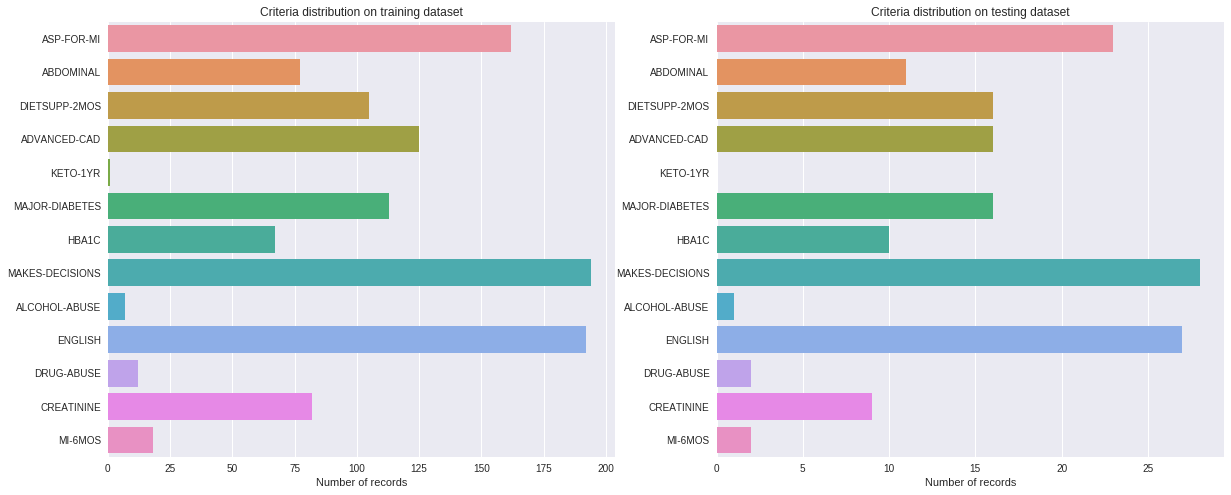

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns  

fig = plt.figure(figsize=(20,8))
(ax_train, ax_test) = fig.subplots(ncols=2, nrows=1)
g1 = sns.barplot(x=train_y.sum(axis=0), y=CATEGORIES, ax=ax_train)
ax_train.set_xlabel('Number of records')
g2 = sns.barplot(x=test_y.sum(axis=0), y=CATEGORIES, ax=ax_test)
ax_test.set_xlabel('Number of records')
g1.set_title("Criteria distribution on training dataset")
g2.set_title("Criteria distribution on testing dataset")

Now we can see the differences in a easier way, we will add weights to the different classes, based on how present they are in the dataset.

In [0]:
# predictions_list[0][0]

In [0]:
# This calculates the weight which will be assigned to the classes when training.
classes = np.add(sum(train_y), sum(test_y))
total_cases = sum(classes)
class_weight = [1 / (c/total_cases) for c in classes]
class_weight = [float(i)/max(class_weight) for i in class_weight]

In [11]:
class_weight

[0.005405405405405405,
 0.011363636363636364,
 0.008264462809917356,
 0.007092198581560284,
 1.0,
 0.007751937984496123,
 0.012987012987012986,
 0.0045045045045045045,
 0.125,
 0.004566210045662101,
 0.07142857142857142,
 0.01098901098901099,
 0.049999999999999996]

In [0]:
# classes

# **Tokenize the dataset and use the word embeddings**

This shows the set of different words ordered by frequency. *tokenizer.word_index*

The text is tokenized and cleaned of stop-words as well as punctuation signs. Also the numbers are substituted by a token "nmbr"

We crop the beggining of the examples because it is the date when they
were written down.

Finally, and after being tokenized, the different sentences are padded to match the maximum length.

max_length == 7813 it is really a huge vector because we have to pad
it afterwards, in order to get it into the CNN

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words=stopwords.words('english')
# Define maximum vocabulary length
MAX_WORDS = 5000
# Defined from the dataset itself. This is used to crop the date from the text.
DATE_LENGTH = 23

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# We are using this function to clean the test set
def tokenize_clean_text(text, tfidf, tokenizer=None, max_length=None, max_words=MAX_WORDS, date_length=DATE_LENGTH):
  """
  This function is in charge of tokenizing the text it is given. It also cleans
  the text from stop-words, punctuation, and gives a special token to numbers.
  
  :param text: The texts to tokenize in a bidimensional python array.
  
  :returns: The tokenized and cleaned text in a bidimensional python array.
            The tokenizer used to preprocess the text.
            The maximum length used for padding.
  """   
  # Consider to stemm or lemmatize the text 
  
  cropped_date_text = [sentence[date_length:] for sentence in text]
    
  # We remove the numbers
  cropped_date_numbers_text = [" ".join([word if not word.isdigit() else ""
                                for word in sentence.split()])
                               for sentence in cropped_date_text]
  
  # Delete stopwords as well as every word less than 3 chars.
  cropped_date_numbers_stopw_text = [" ".join([word if not (word in stop_words or len(word) <= 3) else ""
                                      for word in sentence.split()])
                                     for sentence in cropped_date_numbers_text]
  
  if tfidf:
    vec = TfidfVectorizer(max_features=max_words)
    tfidf_mat = vec.fit_transform(cropped_date_numbers_stopw_text).toarray()
    tfid_words = vec.get_feature_names()

    cropped_date_numbers_stopw_tfidf_text = [" ".join([word if word in tfid_words else ""
                                            for word in sentence.split()])
                                            for sentence in cropped_date_numbers_stopw_text]

    
  
  if tokenizer is None:
    tokenizer = Tokenizer(num_words=max_words) # They use 5k words too
    tokenizer.fit_on_texts(cropped_date_numbers_stopw_tfidf_text if tfidf else cropped_date_numbers_stopw_text)
  # We tokenize the sentences
  tokenized_text = tokenizer.texts_to_sequences(cropped_date_numbers_stopw_tfidf_text if tfidf else cropped_date_numbers_stopw_text)
  
  if max_length == None:
    max_length = 0
    for sentence in tokenized_text:
      max_length = max_length if len(sentence) < max_length else len(sentence)
  
  # Now we return the padded the sequences.
  return pad_sequences(tokenized_text, max_length), tokenizer, max_length, cropped_date_numbers_stopw_tfidf_text if tfidf else cropped_date_numbers_stopw_text
  

# Net Input

Here we take a maximum length of file by obtaining the accumulative density distribution of the training examples. This way we can see how many examples fall under certain threshold. Which will be fixed to 80% of the total examples. This length is 5000 words roughly.

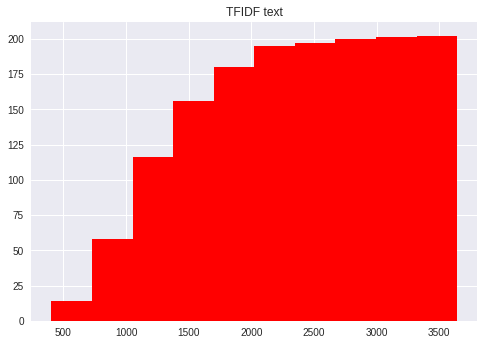

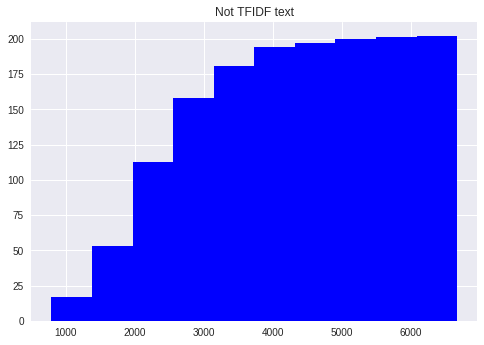

In [15]:
for p in network_parameters:
  p["max_words"] = MAX_WORDS
  
if any([p["tfidf"] for p in network_parameters]):
  train_x_token_tfidf, tokenizer_tfidf, max_length, tfidf_text = tokenize_clean_text(train_x, tfidf=True)
  
  test_x_token_tfidf, _, _, _ = tokenize_clean_text(test_x, tfidf=True, tokenizer=tokenizer_tfidf, max_length=max_length)
  
    
  for p in network_parameters:
    if p["tfidf"]:
      if len(tokenizer_tfidf.word_index) < MAX_WORDS:
        p["max_words"] = len(tokenizer_tfidf.word_index)

      p["max_length"] = max_length

  lenghts = [len(sentence[DATE_LENGTH:].split(" ")) for sentence in tfidf_text]
  plt.hist(lenghts, cumulative=True, color='r')
  plt.title("TFIDF text")
  plt.show()
  
if any([not p["tfidf"] for p in network_parameters]):
  train_x_token, tokenizer, max_length, clean_text = tokenize_clean_text(train_x, tfidf=False)
  
  test_x_token, _, _, _ = tokenize_clean_text(test_x, tfidf=False, tokenizer=tokenizer, max_length=max_length)
  
  for p in network_parameters:
    if not p["tfidf"]:
      if len(tokenizer.word_index) < MAX_WORDS:
        p["max_words"] = len(tokenizer_tfidf.word_index)

      p["max_length"] = max_length

  lenghts = [len(sentence[DATE_LENGTH:].split(" ")) for sentence in clean_text]
  plt.hist(lenghts, cumulative=True, color='b')
  plt.title("Not TFIDF text")
  plt.show()

# **TensorBoard**
TensorBoard is a great tool for DL visualization. It shows the evolution of metrics during the training phase, as well as the weights, distributions, and even the graph of the neural net. 

We will be using tensorboardcolab in order to run a 
TensorBoard instance. This will initialize a ngrok machine and launch TensorBoard for us to see. 

TensorBoard will be accesible by the url 

In [16]:
# We install tensorboard colab in case we don't have it already.
!pip install tensorboardcolab

In [17]:
import tensorboardcolab as tb

tbc=tb.TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://598d45c6.ngrok.io


# Load the embeddings

In this step, we load the word embeddings from the wikipedia, pubmed and PMC. Then we filter them adapting to the words we have in our dataset. This is, if the word appears in the pubmed we take its weights, which are set to 0 otherwise.

In [18]:
# seemingly gensim is not installed in google colab
!pip install gensim

In [0]:
from gensim.models.keyedvectors import KeyedVectors

# PATH_W2V = SST_HOME + "DL/w2v/wikipedia-pubmed-and-PMC-w2v.bin"
PATH_W2V = SST_HOME + "DL/w2v/svd_300.txt"  # word =  d_str[word]
# PATH_W2V = SST_HOME + "DL/w2v/IDX_IPR_C_N_L_month_ALL_MEMBERS_fold1_s300_w20_ss5_hs_thr12.txt"
# PATH_W2V = SST_HOME + "DL/w2v/DeVine_etal_200.txt"

PATH_CUID = SST_HOME + "DL/w2v/CUID/2b_concept_ID_to_CUI.txt"
PATH_STRD = SST_HOME + "DL/w2v/CUID/2a_concept_ID_to_string.txt"

In [20]:
from os import listdir
print(listdir(SST_HOME + "DL/w2v"))

['wikipedia-pubmed-and-PMC-w2v.bin', 'DeVine_etal_200.txt', 'svd_300.txt', 'CUID', 'IDX_IPR_C_N_L_month_ALL_MEMBERS_fold1_s300_w20_ss5_hs_thr12.txt']


In [0]:
def text_to_dict(path, reverse=False):
  d = {}
  with open(path, encoding='latin-1') as f:
      for line in f:
        if reverse:
          val = line.split()[0]
          key = " ".join(line.split()[1:])
        else:
          key = line.split()[0]
          val = " ".join(line.split()[1:])
          
        d[key] = val
  return d
        
def load_W2V_model(path, binary):
    model = KeyedVectors.load_word2vec_format(path, binary=binary)
    print("Binary : {}".format(binary))
    print("Loaded W2V model")
    return model
  
def generate_embedding_weigths(word_index, max_words, model, binary=False):
  # We initialize the embd matrix as random
  # mbedding_matrix = np.zeros((max_words, model.vector_size), dtype=np.float32)
  embedding_matrix = np.random.rand(max_words, model.vector_size)
  d_cuid = text_to_dict(PATH_CUID)
  d_str = text_to_dict(PATH_STRD, reverse=True)
  hit = 0
  for word, i in word_index.items():
    if i >= max_words:
        break
    if not binary:
      try:
        # word = d_cuid[d_str[word]]  # Un-comment if using CUIDS
        word =  d_str[word]  # Un-comment if using concept ids
      except KeyError:
        continue
    if word in model:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = model[word]
        hit += 1
  print("Hits: {}\nTotal: {}".format(hit, i))

  return embedding_matrix

In [22]:
for p in network_parameters:
  p["embedding_matrix"] = None
    
if any([p["load_embeddings"] for p in network_parameters]):
  binary = True if PATH_W2V[-3:]=="bin" else False
  if not 'model' in locals():
    model = load_W2V_model(PATH_W2V, binary)
  # Generate the weights matrix
  
  if any([p["tfidf"] and p["load_embeddings"] for p in network_parameters]):
    p = [p for p in network_parameters if p["tfidf"]][0]
    embedding_matrix_tfidf = generate_embedding_weigths(tokenizer_tfidf.word_index, p["max_words"], model, binary=binary)
  if any([(not p["tfidf"]) and p["load_embeddings"] for p in network_parameters]):
    p = [p for p in network_parameters if not p["tfidf"]][0]
    embedding_matrix = generate_embedding_weigths(tokenizer.word_index, p["max_words"], model, binary=binary)
    
  for p in network_parameters:
    if p["load_embeddings"]: 
      p["embeddings_size"] = model.vector_size
      p["embedding_matrix"] = embedding_matrix if not p["tfidf"] else embedding_matrix_tfidf

Binary : False
Loaded W2V model
Hits: 618
Total: 4348
Hits: 674
Total: 5000


In [0]:
# d_cuid = text_to_dict(PATH_CUID)
# d_str = text_to_dict(PATH_STRD, reverse=True)
# print(d_str["pain"])
# print(d_str.keys()[:100])

**Create a keras Embedding model**

In this section we will create a Keras RNN model, compile, and train it.

In this model we can decide to generate the different embeddings for the words by using a pre-trained embeddings as the wikipedia ones for example.

Some information about the architecture of the net is shown bellow. 

In [0]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, Activation, Embedding, Dropout, Input
from keras.layers import Lambda, Flatten, RepeatVector, Permute, Multiply
from keras.layers import LSTM, GRU, Bidirectional, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Concatenate

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop, Adam

from keras.utils import plot_model

In [0]:
cell_type = {"LSTM": LSTM,
             "GRU": GRU}

for p in network_parameters:
  p["cell_type"] = cell_type[p["cell_type"]]

In [0]:
def add_embeddings(z, load, size, trainable, vocab_size, max_length, embedding_matrix): 
  """
  This method adds embeddings to the network.
  
  Returns the net with the embeddings added.
  """
  if load:
    z = Embedding(vocab_size, size, input_length=max_length, weights=[embedding_matrix], trainable=trainable)(z)
  else:
    z = Embedding(vocab_size, size, input_length=max_length)(z)
    
  return z

def add_cnn(z, size, filter_sizes, flatten):
  """
  This method adds the CNN layers to the network.
  
  Returns the net with the CNN layers.
  """
  conv_blocks = []
  for filter_size in filter_sizes:
    if filter_size is None:
      return z
    conv = None
    for i, cnn_layer in enumerate(size):
      if cnn_layer is None:
        return z
      conv = Conv1D(cnn_layer, filter_size, padding='valid', activation='relu', strides=1)(z if conv is None else conv)
      if (i + 1)  % 2 == 0:
        conv = MaxPooling1D(pool_size=filter_size)(conv)        
      
    if flatten:
      conv = Flatten()(conv)
    conv_blocks.append(conv)         
 
  z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
  
  return z

def add_rnn(z, size, bidirectional, cell_type, attention):
  """
  This method adds the RNN layers to the network. It also adds an attention layer if intended.
  
  Returns the net with the RNN & Attention added.
  """
  for i, rsz in enumerate(size):
    if rsz is None:
      return z
    if not bidirectional:
      if i < len(size) - 1:
        z = cell_type(rsz, return_sequences=True)(z)
      else:
        z = cell_type(rsz, return_sequences=attention)(z)
    else:
      if i < len(size) - 1:
        z = Bidirectional(cell_type(rsz, return_sequences=True))(z)
      else:
        z = Bidirectional(cell_type(rsz, return_sequences=attention))(z)

  if attention:
    z = add_attention(z)

  return z

def add_dnn(z, size, dropout, activation="sigmoid"):
  """
  This method adds the DNN layers to the network.
  
  Returns the net with the DNN layers added.
  """
  for fsz in size:
    if fsz is None:
      return z

    z = Dense(fsz, activation=activation)(z)
    z = Dropout(dropout)(z)
    
  return z

def add_attention(activations):
  """
  This method adds an attention layer.
  
  Returns the model with the attention layer.
  """
  
  size =  K.int_shape(activations)[-1]
  attention = BatchNormalization()(activations)
  attention = Dense(1, activation='tanh')(attention)
  attention = Flatten()(attention)
  attention = Activation('softmax')(attention)
  attention = RepeatVector(size)(attention)
  attention = Permute([2, 1])(attention)
  
  z = Multiply()([activations, attention])
  z = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(size,))(z)

  return z

In [0]:
def create_model(params):
  """
  This method creates a network model with the parameters given.
  
  Returns the uncompiled model.
  """
  inputs = Input(name='inputs',shape=(params["max_length"],))
  
  z = add_embeddings(inputs, params["load_embeddings"], params["embeddings_size"], params["trainable_embeddings"], params["max_words"] ,params["max_length"], params["embedding_matrix"])
  
  # z = add_cnn(z, params["cnn_size"], params["cnn_filter"], [None] == params["rnn_size"])
  
  z = add_rnn(z, params["rnn_size"], params["bidirectional"], params["cell_type"], params["attention"])
  
  z = add_dnn(z, params["dnn_size"], params["dropout"])
  
  outputs = Dense(params["num_classes"], activation='sigmoid', name='output_layer')(z)
  
  net_model = Model(inputs=inputs,outputs=outputs)
  
  return net_model

In [0]:
def create_models(network_parameters, verbose=False):
  model_list = []
  for net_p in network_parameters:
    m = create_model(net_p)
    m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    model_list.append(m)
    
    if verbose:
      m.summary()
      
  return model_list

In [30]:
model_list = create_models(network_parameters, verbose=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 3314)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 3314, 300)    1500000     inputs[0][0]                     
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 3314, 128)    140160      embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidi

# TB Colab Callback
We rewrite the tensorboardcolab callbacks to create different sessions depending on the variables our trainings have. This helps to differentiate the models in tensorboard.

In [0]:
import os
from keras.callbacks import TensorBoard
import tensorflow as tf

class TensorBoardColabCallback(TensorBoard):
    def __init__(self, tbc=None, write_graph=True, name=None, **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'

        if tbc is None:
            return

        log_dir = tbc.get_graph_path()

        training_log_dir = os.path.join(log_dir, 'training_{}'.format(name))
        super(TensorBoardColabCallback, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation_{}'.format(name))

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TensorBoardColabCallback, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}

        for name, value in val_logs.items():
            # print('val_logs:',epoch, name, value)
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TensorBoardColabCallback, self).on_epoch_end(epoch, logs)
        
    def on_train_end(self, logs=None):
        super(TensorBoardColabCallback, self).on_train_end(logs)
        self.val_writer.close()

tb.TensorBoardColabCallback = TensorBoardColabCallback

In [0]:
def define_callbacks(name):
  # Define the callbacks
  tbc_callback = tb.TensorBoardColabCallback(tbc, name=name)  # , histogram_freq=1)
   
  callbacks = [
      ReduceLROnPlateau(),
      EarlyStopping(patience=4),
      tbc_callback
  ]
  return callbacks

In [0]:
# Create an array of names
network_names = []
for p in network_parameters:
  name = "tfidf_{}_load_embeddings_{}_num_classes_{}_embeddings_size_{}_trainable_embeddings_{}_cnn_size_{}_cnn_filter_{}_rnn_size_{}_cell_type_{}_bidirectional_{}_attention_{}_dropout_{}_dnn_size_{}_batch_size_{}".format(
      p["tfidf"], p["load_embeddings"], p["num_classes"], p["embeddings_size"], p["trainable_embeddings"], p["cnn_size"], p["cnn_filter"], p["rnn_size"], 
      str(p["cell_type"]).split(".")[-1].replace("'", "").replace(">", ""), p["bidirectional"],
      p["attention"], p["dropout"], p["dnn_size"], p["batch_size"])
  name = name.replace(" ", "").replace("[", "").replace("]", "").replace(",", "-")
  network_names.append(name)

In [0]:
from keras.models import load_model
for i, net_model in enumerate(model_list):
  # Set a name for the model based on the tweaked parameters
  p = network_parameters[i]
  name = network_names[i]
  model_path = SST_HOME+"DL/models/" + name

  # If the model exists, don't compute it again.
  if os.path.isfile(model_path):
    continue
    
  print("\n\n********************************************\n")    
  print(name)
  callbacks = define_callbacks(name)
  # Fit the model and extract its data
  history = net_model.fit(train_x_token if not network_parameters[i]["tfidf"] else train_x_token_tfidf, train_y, epochs=20, batch_size=network_parameters[i]["batch_size"], 
                          class_weight=class_weight, callbacks=callbacks,
                          validation_split=0.25)
      
  # And save the model
  net_model.save(model_path)
  plot_model(net_model,to_file=name+"model",show_shapes=True)
  
# To free memory from the gpu
from keras import backend as K
K.clear_session()



********************************************

tfidf_False_load_embeddings_True_num_classes_13_embeddings_size_300_trainable_embeddings_False_cnn_size_None_cnn_filter_3_rnn_size_64-64_cell_type_GRU_bidirectional_True_attention_True_dropout_0.3_dnn_size_32_batch_size_None
Instructions for updating:
Use tf.cast instead.
Train on 151 samples, validate on 51 samples
Epoch 1/10
151/151 [==============================] - 114s 755ms/step - loss: 0.6461 - binary_accuracy: 0.6093 - val_loss: 0.5664 - val_binary_accuracy: 0.7496
Epoch 2/10
151/151 [==============================] - 112s 743ms/step - loss: 0.5736 - binary_accuracy: 0.7076 - val_loss: 0.5348 - val_binary_accuracy: 0.7722
Epoch 3/10
151/151 [==============================] - 112s 742ms/step - loss: 0.5469 - binary_accuracy: 0.7336 - val_loss: 0.5184 - val_binary_accuracy: 0.7722
Epoch 4/10
151/151 [==============================] - 112s 741ms/step - loss: 0.5338 - binary_accuracy: 0.7433 - val_loss: 0.5070 - val_binary_accuracy: 0

# SKLearn Predictions

In [0]:
from sklearn.metrics import classification_report
predictions_list = []
for i, net_model in enumerate(model_list):
  print("\n\n********************************************\n")
  print(network_names[i])
  model_path = SST_HOME+"DL/models/" + network_names[i]
  try:
    net_model = load_model(model_path)
  except ValueError:
    print("The model {} was not loaded correctly".format(name))
    continue
    
  predictions = net_model.predict(test_x_token if not network_parameters[i]["tfidf"] else test_x_token_tfidf)
  print(predictions)
  predictions = np.array([[0 if value < 0.5 else 1 for value in prediction] for prediction in predictions])
  predictions_list.append(predictions)
  # measuring performance on test set
  cr=classification_report(test_y, predictions, target_names=CATEGORIES.values)
  print(cr)

  # Release memory
  K.clear_session()


In [0]:
for i, pred in enumerate(predictions_list):
  print(network_names[i])
  print(pred)



#**Generating output in XML format**



In [0]:
import xml.etree.ElementTree
import os
NOT='not met'
MET='met'

#gets a idFile, a dictionary with the predictions (category, label) and the name of the classifier used.
def outputToXML(idFile, dictPred, classifier):
    
    path=SST_HOME+'data/test/xml/'+idFile+'.xml'
    output_dir = SST_HOME+'data/output/'+classifier
    
    output = output_dir+'/'+idFile+'.xml'

    if not os.path.exists(output_dir):
      print("\n\nmaking dir")
      s = os.makedirs(output_dir)
      print(output_dir)
      print(s)      
   
    et = xml.etree.ElementTree.parse(path)

    new_tag = xml.etree.ElementTree.SubElement(et.getroot(), 'TAGS')
    
    for cat in dictPred.keys():
        element = xml.etree.ElementTree.SubElement(new_tag, cat)    
        if dictPred[cat]==0:
            element.attrib['met'] = NOT 
        else:
            element.attrib['met'] = MET

    et.write(output)

#function for creating a dictionary with the categories with values 0 or 1
def iniDictPred(labels, categories):
    
    if len(labels)!=len(categories):
        print('Warning!!!')
        return None
    
    dictPred={}
    i=0
    
    for x in categories:
        dictPred[x]=labels[i]
        i=i+1
    return dictPred

In [0]:
#creates the output xml files per training

for i, predictions in enumerate(predictions_list):
  dictionary = zip(IDFILES, predictions)
  for obj in dictionary:
      idFile=str(obj[0][0])
      labels=obj[1] #gets their predictions for this file
      dictPred=iniDictPred(labels, CATEGORIES) #creates a dictionary to join categories and labels 0,1
      outputToXML(idFile,dictPred,"CRDNN/{}".format(network_names[i]))

  print('output xml files were generated!')

In [0]:
import subprocess
# Writes the output in a file for each training.
for i, name in enumerate(network_names):
  print(name) 
  path = "data/output/CRDNN/"
  n = path + "{}".format(name)
  os.system('cd "{}" && echo "{}" {} {}results.txt'.format(SST_HOME, name, ">" if i == 0 else ">>", path))
  os.system('cd "{}" && python3 track1_eval.py data/test/gold {} >> {}results.txt'.format(SST_HOME, n, path))